When will I win the Great Bear Run?
-----------------------------------------

This notebook presents an application of Bayesian inference to predicting the outcome of a road race.

Copyright 2015 Allen Downey

MIT License: http://opensource.org/licenses/MIT

In [1]:
from __future__ import print_function, division

import thinkbayes2
import thinkplot

import numpy as np
from scipy import stats

%matplotlib inline

Almost every year since 2008 I have participated in the Great Bear Run, a 5K road race in Needham MA.  I usually finish in the top 20 or so, and in my age group I have come in 4th, 6th, 4th, 3rd, 2nd, 4th and 4th.  In 2015 I didn't run because of a scheduling conflict, but based on the results I estimate that I would have come 4th again.

Here are the people who beat me:

In [2]:
data = {
    2008: ['Gardiner', 'McNatt', 'Terry'],
    2009: ['McNatt', 'Ryan', 'Partridge', 'Turner', 'Demers'],
    2010: ['Gardiner', 'Barrett', 'Partridge'],
    2011: ['Barrett', 'Partridge'],
    2012: ['Sager'],
    2013: ['Hammer', 'Wang', 'Hahn'],
    2014: ['Partridge', 'Hughes', 'Smith'],
    2015: ['Barrett', 'Sagar', 'Fernandez'],
}

Having come close in 2012, I have to wonder what my chances of winning are.
I'll try out two different models and see how it goes.

First, a quick function to compute binomial distributions:

In [3]:
def MakeBinomialPmf(n, p):
    ks = range(n+1)
    ps = stats.binom.pmf(ks, n, p)
    pmf = thinkbayes2.Pmf(dict(zip(ks, ps)))
    pmf.Normalize()
    return pmf

###The binomial model

The first model is based on the assumption that there is some population of runners who are faster than me, and who might show up for the Great Bear Run in any given year.  The parameters of the model are the number of runners, $n$, and their probability of showing up, $p$.

The following class uses this model to estimate the parameters from the data.  It extends `thinkbayes.Suite`, which provides a simple framework for Bayesian inference.

The `Likelihood` method computes the likelihood of the data for hypothetical values of $n$ and $p$.  For each year, it computes the number of runners who beat me, $k$, and returns the probability of $k$ given $n$ and $p$.

I explain `Predict` below.

In [4]:
class Bear1(thinkbayes2.Suite, thinkbayes2.Joint):
    def Likelihood(self, data, hypo):
        n, p = hypo
        like = 1
        for year, sobs in data.items():
            k = len(sobs)
            if k > n:
                return 0
            like *= stats.binom.pmf(k, n, p)
        return like
    
    def Predict(self):
        metapmf = thinkbayes2.Pmf()
        for (n, p), prob in bear.Items():
            pmf = MakeBinomialPmf(n, p)
            metapmf[pmf] = prob
        mix = thinkbayes2.MakeMixture(metapmf)
        return mix

The prior distribution for $n$ is uniform from 16 to 70 (16 is the number of unique runners who have beat me; 70 is an arbitrary upper bound).

The prior distribution for $p$ is uniform from 0 to 1.

In [5]:
hypos = [(n, p) for n in range(16, 70) 
                for p in np.linspace(0, 1, 101)]
bear = Bear1(hypos)

Next we update `bear` with the data.
The `Update` function is provided by `thinkbayes.Suite`; it computes the likelihood of the data for each hypothesis, multiplies by the prior probabilities, and renormalizes.

The return value is the normalizing constant, which is total probability of the data under the prior (but otherwise not particularly meaningful).

In [6]:
bear.Update(data)

9.7429617466130483e-08

From the joint posterior distribution we can extract the marginal distributions of $n$ and $p$.

The following figure shows the posterior distribution of $n$.  The most likely value is 16; that is, we have already seen the entire population of runners.  But the mean is almost 35.

At the upper bound, the posterior probability is non-negligible, which suggests that higher values are possible.  If I were attached to this model, I might work on refining the prior for $n$.

34.859286458692274

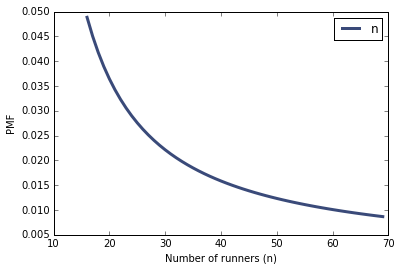

In [7]:
pmf_n = bear.Marginal(0)
thinkplot.PrePlot(5)
thinkplot.Pdf(pmf_n, label='n')
thinkplot.Config(xlabel='Number of runners (n)', 
                 ylabel='PMF', loc='upper right')
pmf_n.Mean()

The posterior distribution for $p$ is better behaved.  The credible interval is between 4% and 21%.

(0.040000000000000001, 0.20999999999999999)

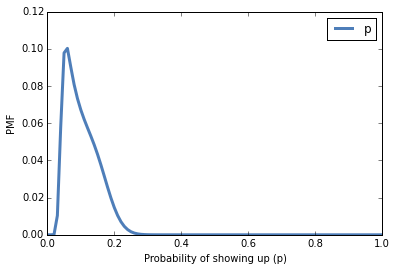

In [8]:
pmf_p = bear.Marginal(1)
thinkplot.Pdf(pmf_p, label='p')
thinkplot.Config(xlabel='Probability of showing up (p)', 
                 ylabel='PMF', loc='upper right')
pmf_p.CredibleInterval(95)

The following figure shows the joint distribution of $n$ and $p$.  They are inversely related: the more people there are, the less often they each show up.

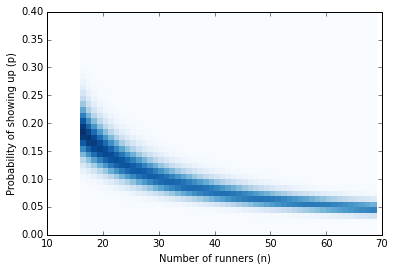

In [26]:
thinkplot.Contour(bear, pcolor=True, contour=False)
thinkplot.Config(xlabel='Number of runners (n)',
                 ylabel='Probability of showing up (p)',
                 ylim=[0, 0.4])

Finally, we can generate a predictive distribution for the number of people who will finish ahead of me, $k$.  For each pair of $n$ and $p$, the distribution of $k$ is binomial.  So the predictive distribution is a weighted mixture of binomials (see `Bear1.Predict` above).

The most likely outcomes are 2 or 3 people ahead of me.  The probability that I win my age group is about 5%.

0.052046954456205601

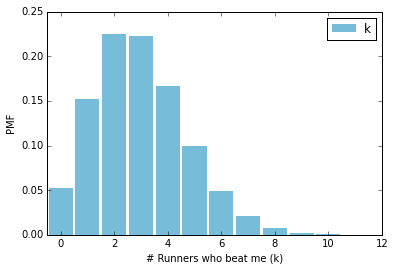

In [10]:
predict = bear.Predict()
thinkplot.Hist(predict, label='k')
thinkplot.Config(xlabel='# Runners who beat me (k)',
                 ylabel='PMF', xlim=[-0.5, 12])
predict[0]

###A better model

The binomial model is simple, but it ignores potentially useful information: from previous results, we can see that the same people appear more than once.  We can use this data to improve our estimate of the total population.

For example, if the same people appear over and over, that's evidence for smaller values of $n$.  If the same person seldom appears twice, that's evidence for larger values.

To quantify that effect, we need a model of the sampling process.
In order to displace me, a runner has to

1. **S**how up
2. **O**utrun me
3. **B**e in my age group

For each runner, the probability of displacing me is a product of these factors:

$p_i = SOB$

Some runners have a higher SOB factor than others; we can use previous results to estimate it.

But first we have to think about an appropriate prior.  Based on my experience, I conjecture that the prior distribution of $S$ is an increasing function, with many people who run nearly every year, and fewer who run only occasionally:

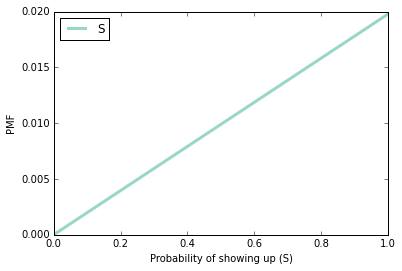

In [11]:
ss = thinkbayes2.Beta(2, 1)
thinkplot.Pdf(ss.MakePmf(), label='S')
thinkplot.Config(xlabel='Probability of showing up (S)',
                 ylabel='PMF', loc='upper left')

The prior distribution of $O$ is biased toward high values.  Of the people who have the potential to beat me, many of them will beat me every time.  I am only competitive with a few of them.

(For example, of the 16 people who have beat me, I have only ever beat 2).

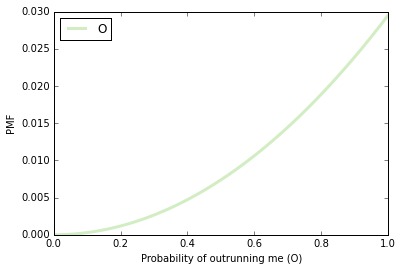

In [12]:
os = thinkbayes2.Beta(3, 1)
thinkplot.Pdf(os.MakePmf(), label='O')
thinkplot.Config(xlabel='Probability of outrunning me (O)',
                 ylabel='PMF', loc='upper left')

The probability that a runner is in my age group depends on the difference between his age and mine.  Someone exactly my age will always be in my age group.  Someone 4 years older will be in my age group only once every 5 years (the Great Bear run uses 5-year age groups).

So the distribution of $B$ is uniform.

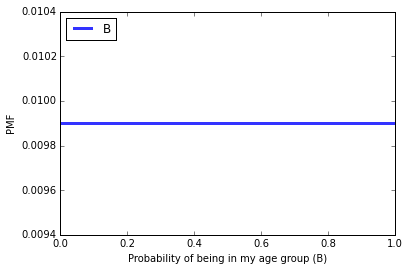

In [13]:
bs = thinkbayes2.Beta(1, 1)
thinkplot.Pdf(bs.MakePmf(), label='B')
thinkplot.Config(xlabel='Probability of being in my age group (B)',
                 ylabel='PMF', loc='upper left')

I used Beta distributions for each of the three factors, so each $p_i$ is the product of three Beta-distributed variates.  In general, the result is not a Beta distribution, but maybe we can find a Beta distribution that is a good approximation of the actual distribution.

I'll draw a sample from the distributions of $S$, $O$, and $B$, and multiply them out. It turns out that the result is a good match for a Beta distribution with parameters 1 and 3.

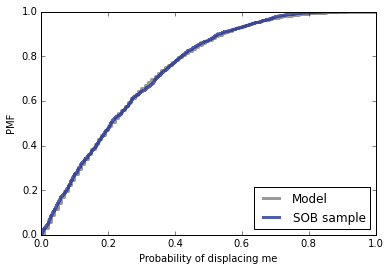

In [14]:
n = 1000
sample = ss.Sample(n) * os.Sample(n) * bs.Sample(n)
cdf = thinkbayes2.Cdf(sample)

thinkplot.PrePlot(1)

prior = thinkbayes2.Beta(1, 3)
thinkplot.Cdf(prior.MakeCdf(), color='grey', label='Model')
thinkplot.Cdf(cdf, label='SOB sample')
thinkplot.Config(xlabel='Probability of displacing me',
                 ylabel='PMF', loc='lower right')

Now let's look more carefully at the data.  There are 16 people who have displaced me during at least one year, several more than once.

The runner with the biggest SOB factor is Rich Partridge, who has displaced me in 4 of 8 years.  In fact, he outruns me almost every year, but is not always in my age group.

In [15]:
from itertools import chain
from collections import Counter

counter = Counter(chain(*data.values()))
len(counter), counter

(16,
 Counter({'Partridge': 4, 'Barrett': 3, 'Gardiner': 2, 'McNatt': 2, 'Demers': 1, 'Hughes': 1, 'Hahn': 1, 'Wang': 1, 'Smith': 1, 'Ryan': 1, 'Sager': 1, 'Sagar': 1, 'Terry': 1, 'Turner': 1, 'Hammer': 1, 'Fernandez': 1}))

The following function makes a Beta distribution to represent the posterior distribution of $p_i$ for each runner.  It starts with the prior, Beta(1, 3), and updates it with the number of times the runner displaces me, and the number of times he doesn't.

In [16]:
def MakeBeta(count, num_races, precount=3):
    beta = thinkbayes2.Beta(1, precount)
    beta.Update((count, num_races-count))
    return beta

Now we can make a posterior distribution for each runner:

In [17]:
num_races = len(data)
betas = [MakeBeta(count, num_races) 
         for count in counter.values()]

Let's check the posterior means to see if they make sense.  For Rich Partridge, who has displaced me 4 times out of 8, the posterior mean is 42%; for someone who has displaced me only once, it is 17%.

So those don't seem crazy.

In [18]:
[beta.Mean() for beta in betas]

[0.16666666666666666,
 0.16666666666666666,
 0.16666666666666666,
 0.16666666666666666,
 0.25,
 0.16666666666666666,
 0.16666666666666666,
 0.16666666666666666,
 0.25,
 0.16666666666666666,
 0.16666666666666666,
 0.4166666666666667,
 0.16666666666666666,
 0.16666666666666666,
 0.16666666666666666,
 0.3333333333333333]

Now we're ready to do some inference.  The model only has one parameter, the total number of runners who could displace me, $n$.  For the 16 SOBS we have actually observed, we use previous results to estimate $p_i$.  For additional hypothetical runners, we update the distribution with 0 displacements out of `num_races`.

To improve performance, my implementation precomputes the distribution of $k$ for each value of $n$, using `ComputePmfs` and `ComputePmf`.

After that, the `Likelihood` function is simple: it just looks up the probability of $k$ given $n$.

In [19]:
class Bear2(thinkbayes2.Suite, thinkbayes2.Joint):

    def ComputePmfs(self, data):
        num_races = len(data)
        counter = Counter(chain(*data.values()))
        betas = [MakeBeta(count, num_races) 
                 for count in counter.values()]
        
        self.pmfs = dict()
        low = len(betas)
        high = max(self.Values())
        for n in range(low, high+1):
            self.pmfs[n] = self.ComputePmf(betas, n, num_races)
    
    def ComputePmf(self, betas, n, num_races, label=''):
        no_show = MakeBeta(0, num_races)
        all_betas = betas + [no_show] * (n - len(betas))
        
        ks = []
        for i in range(2000):
            ps = [beta.Random() for beta in all_betas]
            xs = np.random.random(len(ps))
            k = sum(xs < ps)
            ks.append(k)
            
        return thinkbayes2.Pmf(ks, label=label)
    
    def Likelihood(self, data, hypo):
        n = hypo
        k = data
        return self.pmfs[n][k]
    
    def Predict(self):
        metapmf = thinkbayes2.Pmf()
        for n, prob in self.Items():
            pmf = bear2.pmfs[n]
            metapmf[pmf] = prob
        mix = thinkbayes2.MakeMixture(metapmf)
        return mix

Here's what some of the precomputed distributions look like, for several values of $n$.

If there are fewer runners, my chance of winning is slightly better, but the difference is small, because fewer runners implies a higher mean for $p_i$.

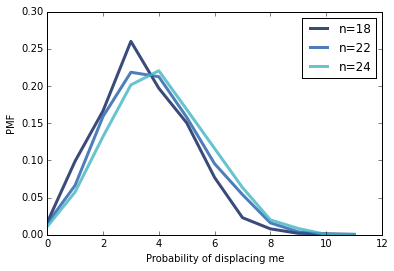

In [20]:
bear2 = Bear2()

thinkplot.PrePlot(3)
pmf = bear2.ComputePmf(betas, 18, num_races, label='n=18')
pmf2 = bear2.ComputePmf(betas, 22, num_races, label='n=22')
pmf3 = bear2.ComputePmf(betas, 26, num_races, label='n=24')
thinkplot.Pdfs([pmf, pmf2, pmf3])
thinkplot.Config(xlabel='Probability of displacing me',
                 ylabel='PMF', loc='upper right')

For the prior distribution of $n$, I'll use a uniform distribution from 16 to 35 (this upper bound turns out to be sufficient).

In [21]:
low = 16
high = 35
bear2 = Bear2(range(low, high))
bear2.ComputePmfs(data)

And here's the update, using the number of runners who displaced me each year:

In [22]:
for year, sobs in data.items():
    k = len(sobs)
    bear2.Update(k)

Here's the posterior distribution of $n$.  It's noisy because I used random sampling to estimate the conditional distributions of $k$.  But that's ok because we don't really care about $n$; we care about the predictive distribution of $k$.  And noise in the distribution of $n$ has very little effect on $k$.

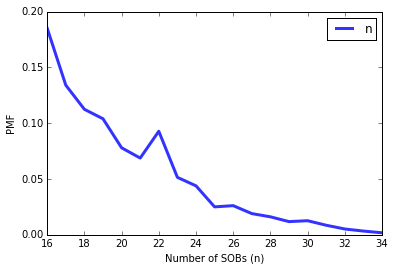

In [23]:
thinkplot.Pdf(bear2, label='n')
thinkplot.Config(xlabel='Number of SOBs (n)',
                 ylabel='PMF', loc='upper right')

The predictive distribution for $k$ is a weighted mixture of the conditional distributions we already computed:

In [24]:
predict = bear2.Predict()

And here's what it looks like:

0.018129857757334864

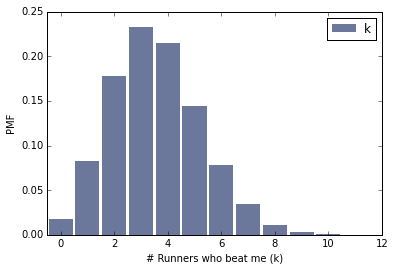

In [25]:
thinkplot.Hist(predict, label='k')
thinkplot.Config(xlabel='# Runners who beat me (k)', ylabel='PMF', xlim=[-0.5, 12])
predict[0]

According to this model, my chance of winning my age groups is less than 2%, which is more pessimistic than the results from the binomial model, about 5%.